In [1]:
import os
while not (os.getcwd().split('\\')[-1] == 'ecological-networks' or os.getcwd().split('/')[-1] == 'ecological-networks'):
    %cd ..
import setup_paths
setup_paths.add_path()
from Species_Reintroductions import *
global DATA_TYPE
DATA_TYPE = 'Real_1D'
CASE_TO_SOLVE_init(DATA_TYPE)
get_CASE()

def CASE_init(CASE_TO_SOLVE):
    DATA_TYPE = CASE_TO_SOLVE
    CASE_TO_SOLVE_init(DATA_TYPE)
    NetworkName_Solved_df = UnpickleObj(os.path.join(os.getcwd(), 'Code', '01_Species_Reintroductions', '01_Simulation_Execution', f"Network_Solved_{DATA_TYPE.split('_')[0]}.pkl"))
    M = UnpickleObj(os.path.join(os.getcwd(), 'Code', '01_Species_Reintroductions', '01_Simulation_Execution', f"M_{DATA_TYPE.split('_')[0]}.pkl"))
    if DATA_TYPE.split('_')[0] == 'Syn':
        M = {k:M[k] for k in M.keys() if int(k.split('_')[2]) == 100}
    return DATA_TYPE, NetworkName_Solved_df, M

from scipy.optimize import fsolve
from scipy import stats
import scipy.linalg as la
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing


d:\Github\ecological-networks\Code\01_Species_Reintroductions
d:\Github\ecological-networks\Code
d:\Github\ecological-networks
Real_1D


In [14]:
DATA_TYPE, NetworkName_Solved_df, M = CASE_init('Real_4D')
loc = '04'
X = {}
for NetworkName in M.keys():
    FileName = os.path.join(os.getcwd(), 'Code', '01_Species_Reintroductions', '05_Analysis', 'Dyna_SR', f"{loc}", f"{NetworkName}.pkl")
    X[NetworkName] = UnpickleObj(FileName)


In [15]:
print(type(X))
print(X.keys())
#for key in X.keys():
    #print(key, ' : ', X[key].shape)
#print(list(X[key].columns))
#del key
print([(i,v) for i,v in enumerate(list(X[list(X.keys())[0]].columns))])

<class 'dict'>
dict_keys(['M_PL_003', 'M_PL_022', 'M_PL_060_04', 'M_PL_060_07', 'M_PL_060_06', 'M_PL_040', 'M_PL_041', 'M_PL_030', 'M_PL_012', 'M_PL_060_05', 'M_PL_072_04', 'M_PL_023', 'M_PL_072_02', 'M_PL_031', 'M_PL_035', 'M_PL_017', 'M_PL_072_01', 'M_PL_010', 'M_PL_002', 'M_PL_043', 'M_PL_014', 'M_PL_058', 'M_PL_072_03', 'M_PL_019', 'M_PL_009', 'M_PL_018', 'M_PL_034', 'M_PL_026', 'M_PL_029', 'M_PL_028'])
[(0, 'n'), (1, 'm'), (2, 'L'), (3, 'S'), (4, 'A'), (5, 'C'), (6, 'N'), (7, 'g_p'), (8, 'g_a'), (9, 'beta_eff_p'), (10, 'beta_eff_a'), (11, 'Abundance'), (12, 'Ob Abundance'), (13, 'Settling Time'), (14, 'Persistence')]


In [16]:
for key in X.keys():
    Y = X[key].copy()
    Y.drop_duplicates(inplace=True, ignore_index=True)
    print(key, ' : ', X[key].shape, ' : ', Y.shape, ' : ', X[key].shape[0]-Y.shape[0])

M_PL_003  :  (11864, 15)  :  (9312, 15)  :  2552
M_PL_022  :  (7000, 15)  :  (5361, 15)  :  1639
M_PL_060_04  :  (7200, 15)  :  (5094, 15)  :  2106
M_PL_060_07  :  (9840, 15)  :  (8027, 15)  :  1813
M_PL_060_06  :  (8544, 15)  :  (7287, 15)  :  1257
M_PL_040  :  (9728, 15)  :  (8478, 15)  :  1250
M_PL_041  :  (10320, 15)  :  (8961, 15)  :  1359
M_PL_030  :  (9480, 15)  :  (8082, 15)  :  1398
M_PL_012  :  (9672, 15)  :  (8098, 15)  :  1574
M_PL_060_05  :  (10800, 15)  :  (9583, 15)  :  1217
M_PL_072_04  :  (8376, 15)  :  (6476, 15)  :  1900
M_PL_023  :  (7388, 15)  :  (5771, 15)  :  1617
M_PL_072_02  :  (10740, 15)  :  (9300, 15)  :  1440
M_PL_031  :  (15960, 15)  :  (15031, 15)  :  929
M_PL_035  :  (20160, 15)  :  (19156, 15)  :  1004
M_PL_017  :  (8472, 15)  :  (6212, 15)  :  2260
M_PL_072_01  :  (12888, 15)  :  (11394, 15)  :  1494
M_PL_010  :  (10320, 15)  :  (8208, 15)  :  2112
M_PL_002  :  (14160, 15)  :  (12967, 15)  :  1193
M_PL_043  :  (9480, 15)  :  (8086, 15)  :  1394
M_PL_01

In [17]:
DF = pd.DataFrame([], columns=list(Y.columns))
for key in X.keys():
    X[key] = X[key].apply(pd.to_numeric)
    X[key].drop_duplicates(inplace=True, ignore_index=True)
    X[key].drop(X[key][ X[key]['Ob Abundance'] == 0 ].index ,inplace = True)
    DF = pd.concat([DF,X[key]], ignore_index = True)
DF = DF.apply(pd.to_numeric)
DF.sort_values(by = ['Abundance', 'Ob Abundance'], axis = 0, inplace = True, ignore_index = True)
DF.drop(DF[ DF['Ob Abundance'] == 0 ].index ,inplace = True)
DF.reset_index(drop = True, inplace = True)

print(DF.shape)
DF.describe()

(304960, 15)


n              m              L              S  \
count  304960.000000  304960.000000  304960.000000  304960.000000   
mean       29.257811      62.306404     168.540963      91.564215   
std        18.636173      27.781606      87.137343      33.505863   
min         1.000000       1.000000       1.000000       2.000000   
25%        18.000000      42.000000     105.000000      67.000000   
50%        25.000000      54.000000     152.000000      88.000000   
75%        34.000000      78.000000     213.250000     110.000000   
max       105.000000     139.000000     456.000000     180.000000   

                   A              C              N            g_p  \
count  304960.000000  304960.000000  304940.000000  304960.000000   
mean        2.832486       0.115158       0.236870       2.338009   
std         1.951993       0.054611       0.074922       0.701121   
min         0.166667       0.034815       0.000000       1.000000   
25%         1.583333       0.082755       0.181375       1.846559   
50%         2.468750       0.101769       0.232254       2.196652   
75%         3.535714       0.134146       0.278652       2.811849   
max        36.500000       1.000000       1.000000       6.510034   

                 g_a     beta_eff_p     beta_eff_a      Abundance  \
count  304960.000000  304517.000000  304748.000000  304960.000000   
mean        1.483809      12.346730       7.940002       0.608448   
std         0.192085       6.891452       3.136721       0.096338   
min         1.000000       1.000000       1.000000       0.152656   
25%         1.365367       6.572772       5.468316       0.535975   
50%         1.474024      11.149651       7.915596       0.619506   
75%         1.566995      16.822925       9.410196       0.675048   
max         2.321560      36.375663      19.935677       0.894805   

        Ob Abundance  Settling Time    Persistence  
count  304960.000000  304960.000000  304960.000000  
mean        0.601850     116.106876       2.418791  
std         0.103249       9.772606       1.012405  
min         0.013233      91.000000       0.032787  
25%         0.529335     109.000000       1.590164  
50%         0.614369     116.000000       2.384615  
75%         0.673297     121.000000       3.025000  
max         0.894751     167.000000       5.615385

In [18]:
D = DF.copy()
for Col_Name in list(DF.columns):
    
    X_scaled = preprocessing.MinMaxScaler().fit_transform(np.array(D[Col_Name]).reshape(-1,1))
    D[Col_Name] = X_scaled
del Col_Name, X_scaled
D.corr()


n         m         L         S         A         C  \
n              1.000000  0.003398  0.251525  0.559024 -0.565347 -0.660497   
m              0.003398  1.000000  0.825243  0.831046  0.482170 -0.151218   
L              0.251525  0.825243  1.000000  0.824155  0.155037 -0.141158   
S              0.559024  0.831046  0.824155  1.000000  0.085345 -0.492756   
A             -0.565347  0.482170  0.155037  0.085345  1.000000  0.587147   
C             -0.660497 -0.151218 -0.141158 -0.492756  0.587147  1.000000   
N             -0.011806 -0.090435  0.102608 -0.081558  0.172348  0.448981   
g_p           -0.512372  0.636801  0.556154  0.243023  0.804677  0.586911   
g_a            0.340916  0.052615  0.543303  0.233246 -0.361667 -0.050706   
beta_eff_p    -0.281402  0.653409  0.731435  0.385551  0.518056  0.391665   
beta_eff_a     0.383771  0.391393  0.797599  0.538512 -0.212692 -0.138390   
Abundance     -0.198582 -0.455662 -0.210175 -0.488268 -0.335596  0.139912   
Ob Abundance  -0.173624 -0.429948 -0.190914 -0.453065 -0.312070  0.113897   
Settling Time  0.267243 -0.123790 -0.127687  0.046001 -0.373238 -0.434907   
Persistence   -0.291320  0.771658  0.593060  0.477791  0.539111  0.055433   

                      N       g_p       g_a  beta_eff_p  beta_eff_a  \
n             -0.011806 -0.512372  0.340916   -0.281402    0.383771   
m             -0.090435  0.636801  0.052615    0.653409    0.391393   
L              0.102608  0.556154  0.543303    0.731435    0.797599   
S             -0.081558  0.243023  0.233246    0.385551    0.538512   
A              0.172348  0.804677 -0.361667    0.518056   -0.212692   
C              0.448981  0.586911 -0.050706    0.391665   -0.138390   
N              1.000000  0.285843  0.326366    0.465580    0.225404   
g_p            0.285843  1.000000  0.118467    0.855661    0.281642   
g_a            0.326366  0.118467  1.000000    0.415878    0.831790   
beta_eff_p     0.465580  0.855661  0.415878    1.000000    0.506096   
beta_eff_a     0.225404  0.281642  0.831790    0.506096    1.000000   
Abundance      0.238108 -0.097424  0.428225    0.010210    0.150058   
Ob Abundance   0.261973 -0.077111  0.434244    0.028882    0.164946   
Settling Time -0.435974 -0.444188  0.085035   -0.356734   -0.045172   
Persistence    0.020251  0.676353  0.028694    0.705361    0.231203   

               Abundance  Ob Abundance  Settling Time  Persistence  
n              -0.198582     -0.173624       0.267243    -0.291320  
m              -0.455662     -0.429948      -0.123790     0.771658  
L              -0.210175     -0.190914      -0.127687     0.593060  
S              -0.488268     -0.453065       0.046001     0.477791  
A              -0.335596     -0.312070      -0.373238     0.539111  
C               0.139912      0.113897      -0.434907     0.055433  
N               0.238108      0.261973      -0.435974     0.020251  
g_p            -0.097424     -0.077111      -0.444188     0.676353  
g_a             0.428225      0.434244       0.085035     0.028694  
beta_eff_p      0.010210      0.028882      -0.356734     0.705361  
beta_eff_a      0.150058      0.164946      -0.045172     0.231203  
Abundance       1.000000      0.993434       0.120461    -0.112687  
Ob Abundance    0.993434      1.000000       0.096695    -0.087945  
Settling Time   0.120461      0.096695       1.000000    -0.081683  
Persistence    -0.112687     -0.087945      -0.081683     1.000000

(0.0, 1.0)

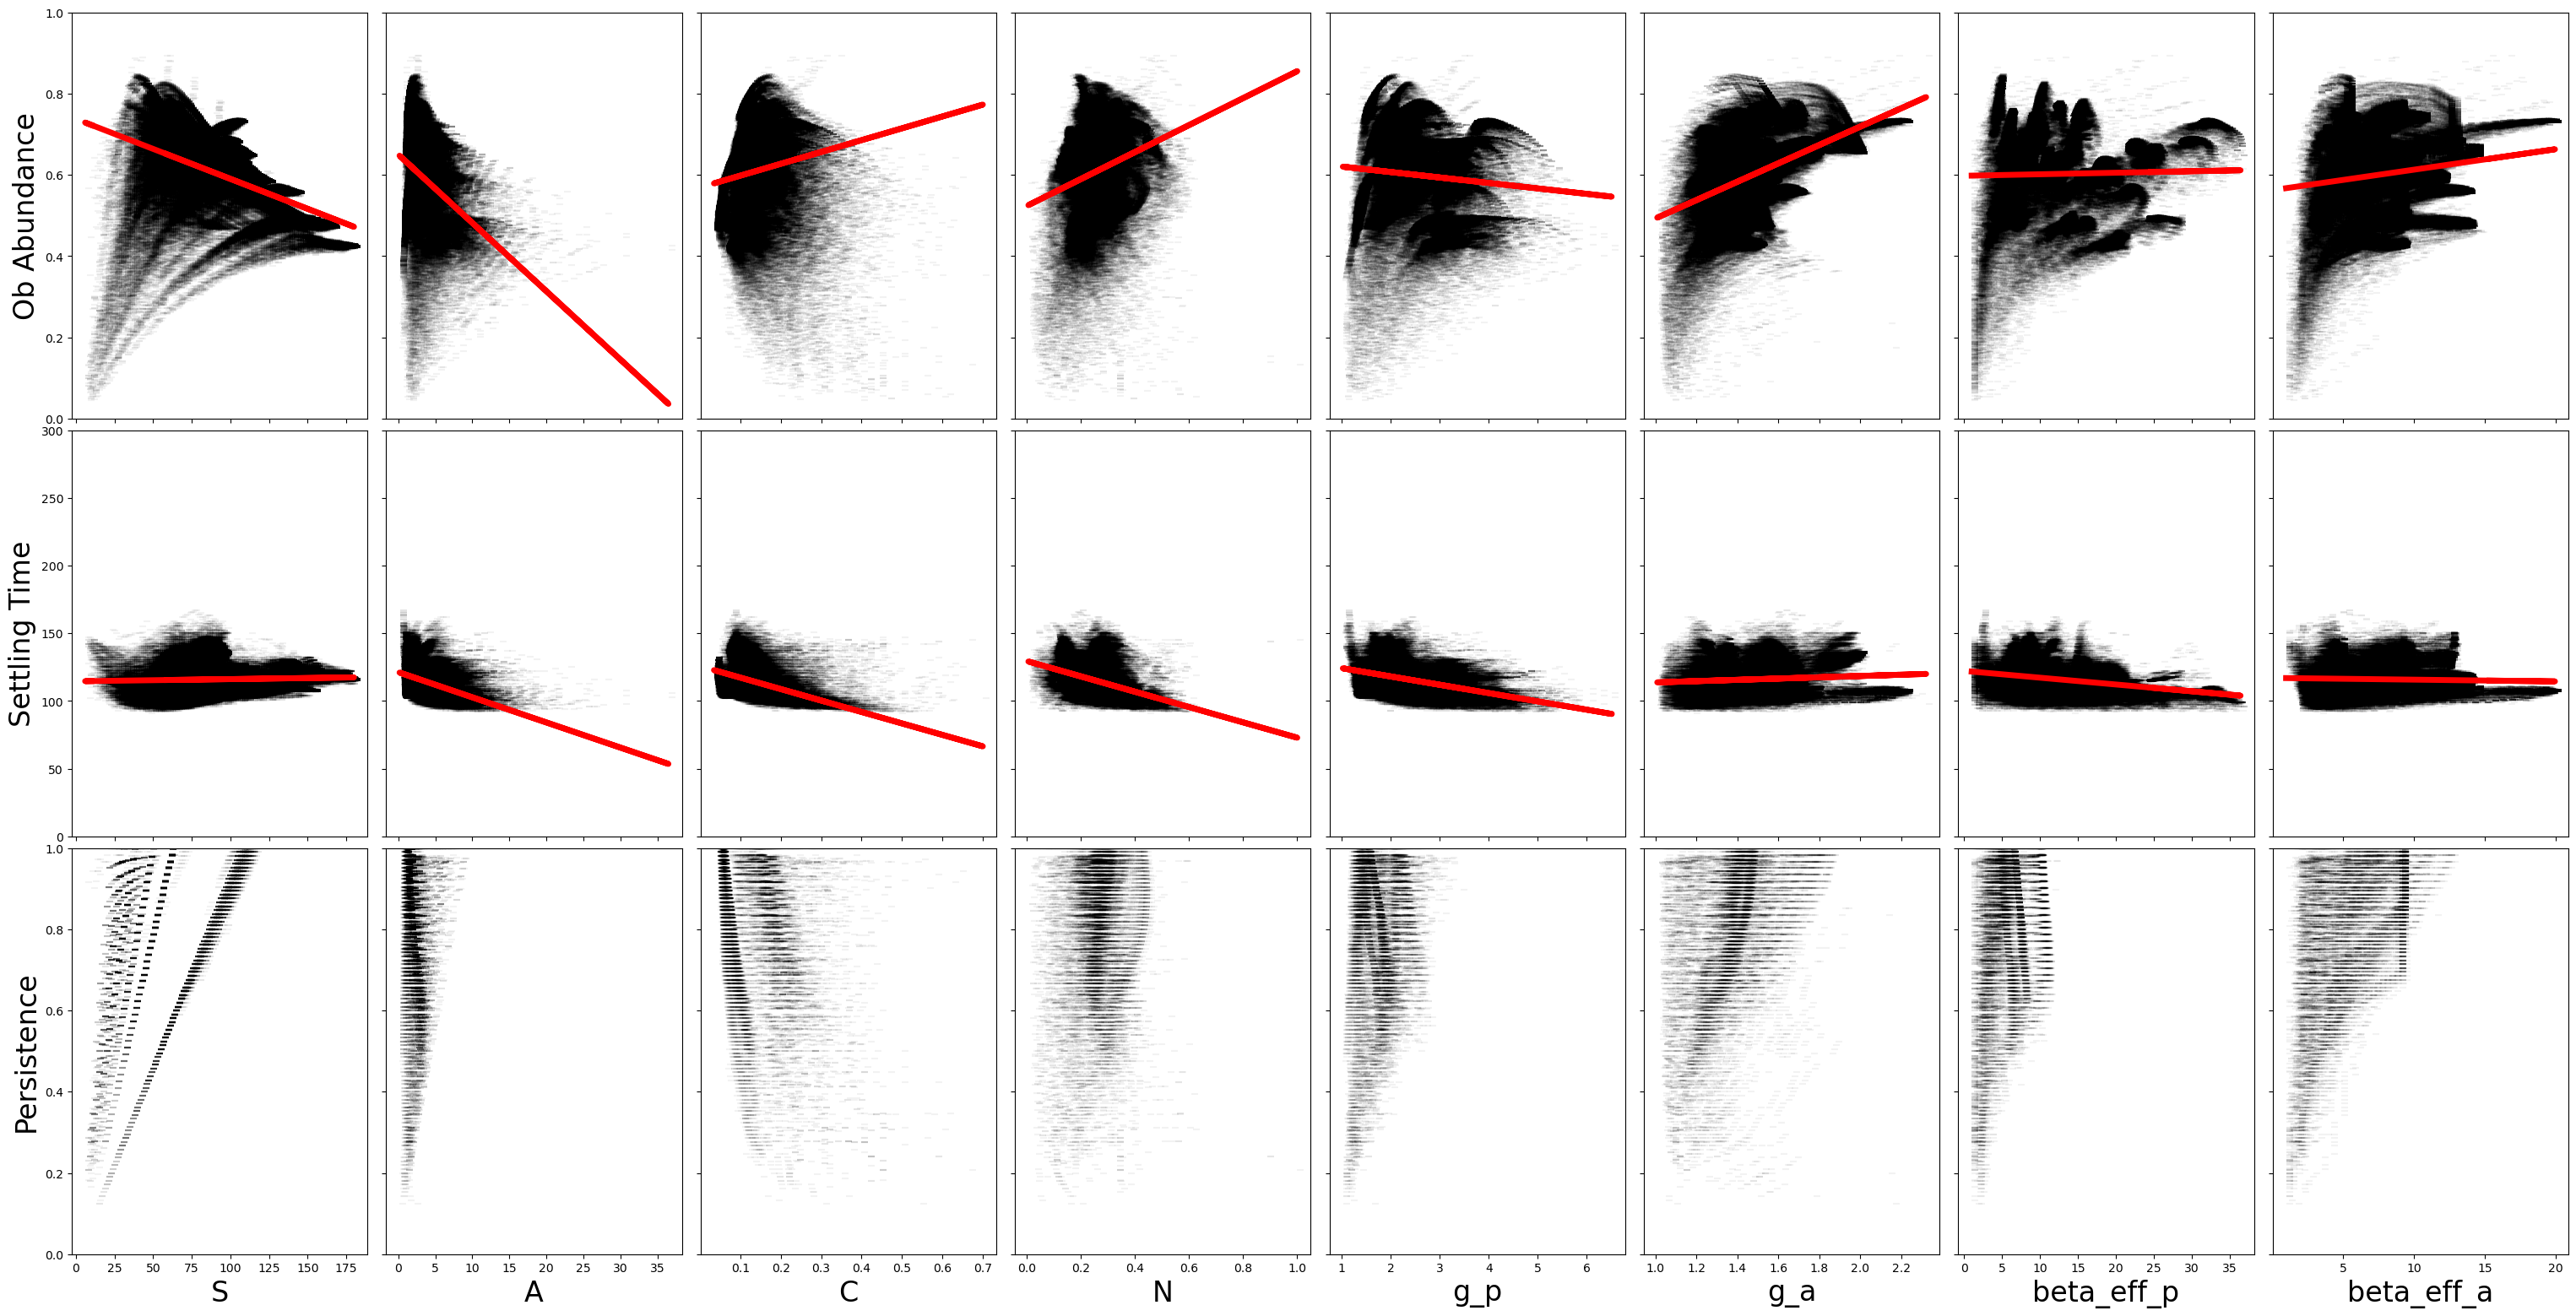

In [23]:
D = DF.copy()
D.drop(D[ D['N'] == 0 ].index ,inplace = True)
D.dropna(axis = 0, inplace = True)
#D = D[D['Abundance'] > 1.0]
D.reset_index(drop = True, inplace = True)

f, ax = plt.subplots(3,4+4, figsize = (30,15), dpi = 100, sharey = 'row', sharex = 'col')
f.tight_layout(pad = 0)

V_lst = ['S','A','C','N', 'g_p', 'g_a', 'beta_eff_p', 'beta_eff_a']
Vy_lst = ['Ob Abundance', 'Settling Time', 'Persistence']

for row, Vy in enumerate(Vy_lst):
    for col, V in enumerate(V_lst):

        X_seq = np.array(D[V]).reshape(-1,1)
        Y_seq = np.array(D[Vy]).reshape(-1,1)

        #if Vy == 'Ob Abundance':
            #Y_seq = (Y_seq - 0) / (14-0)
        
        ax[row,col].scatter(X_seq,Y_seq, alpha = 0.05, color = 'black', marker = 1)

        regr = LinearRegression().fit(X_seq,Y_seq)
        ax[row,col].plot(X_seq,regr.predict(X_seq),color="red", linewidth = 5)

        ax[-1, col].set_xlabel(V, fontsize = 24)
        ax[row, 0].set_ylabel(Vy, fontsize = 24)

ax[0,0].set_ylim([0.0, 1.0])
ax[1,0].set_ylim([0, 300])
ax[2,0].set_ylim([0.0, 1.0])

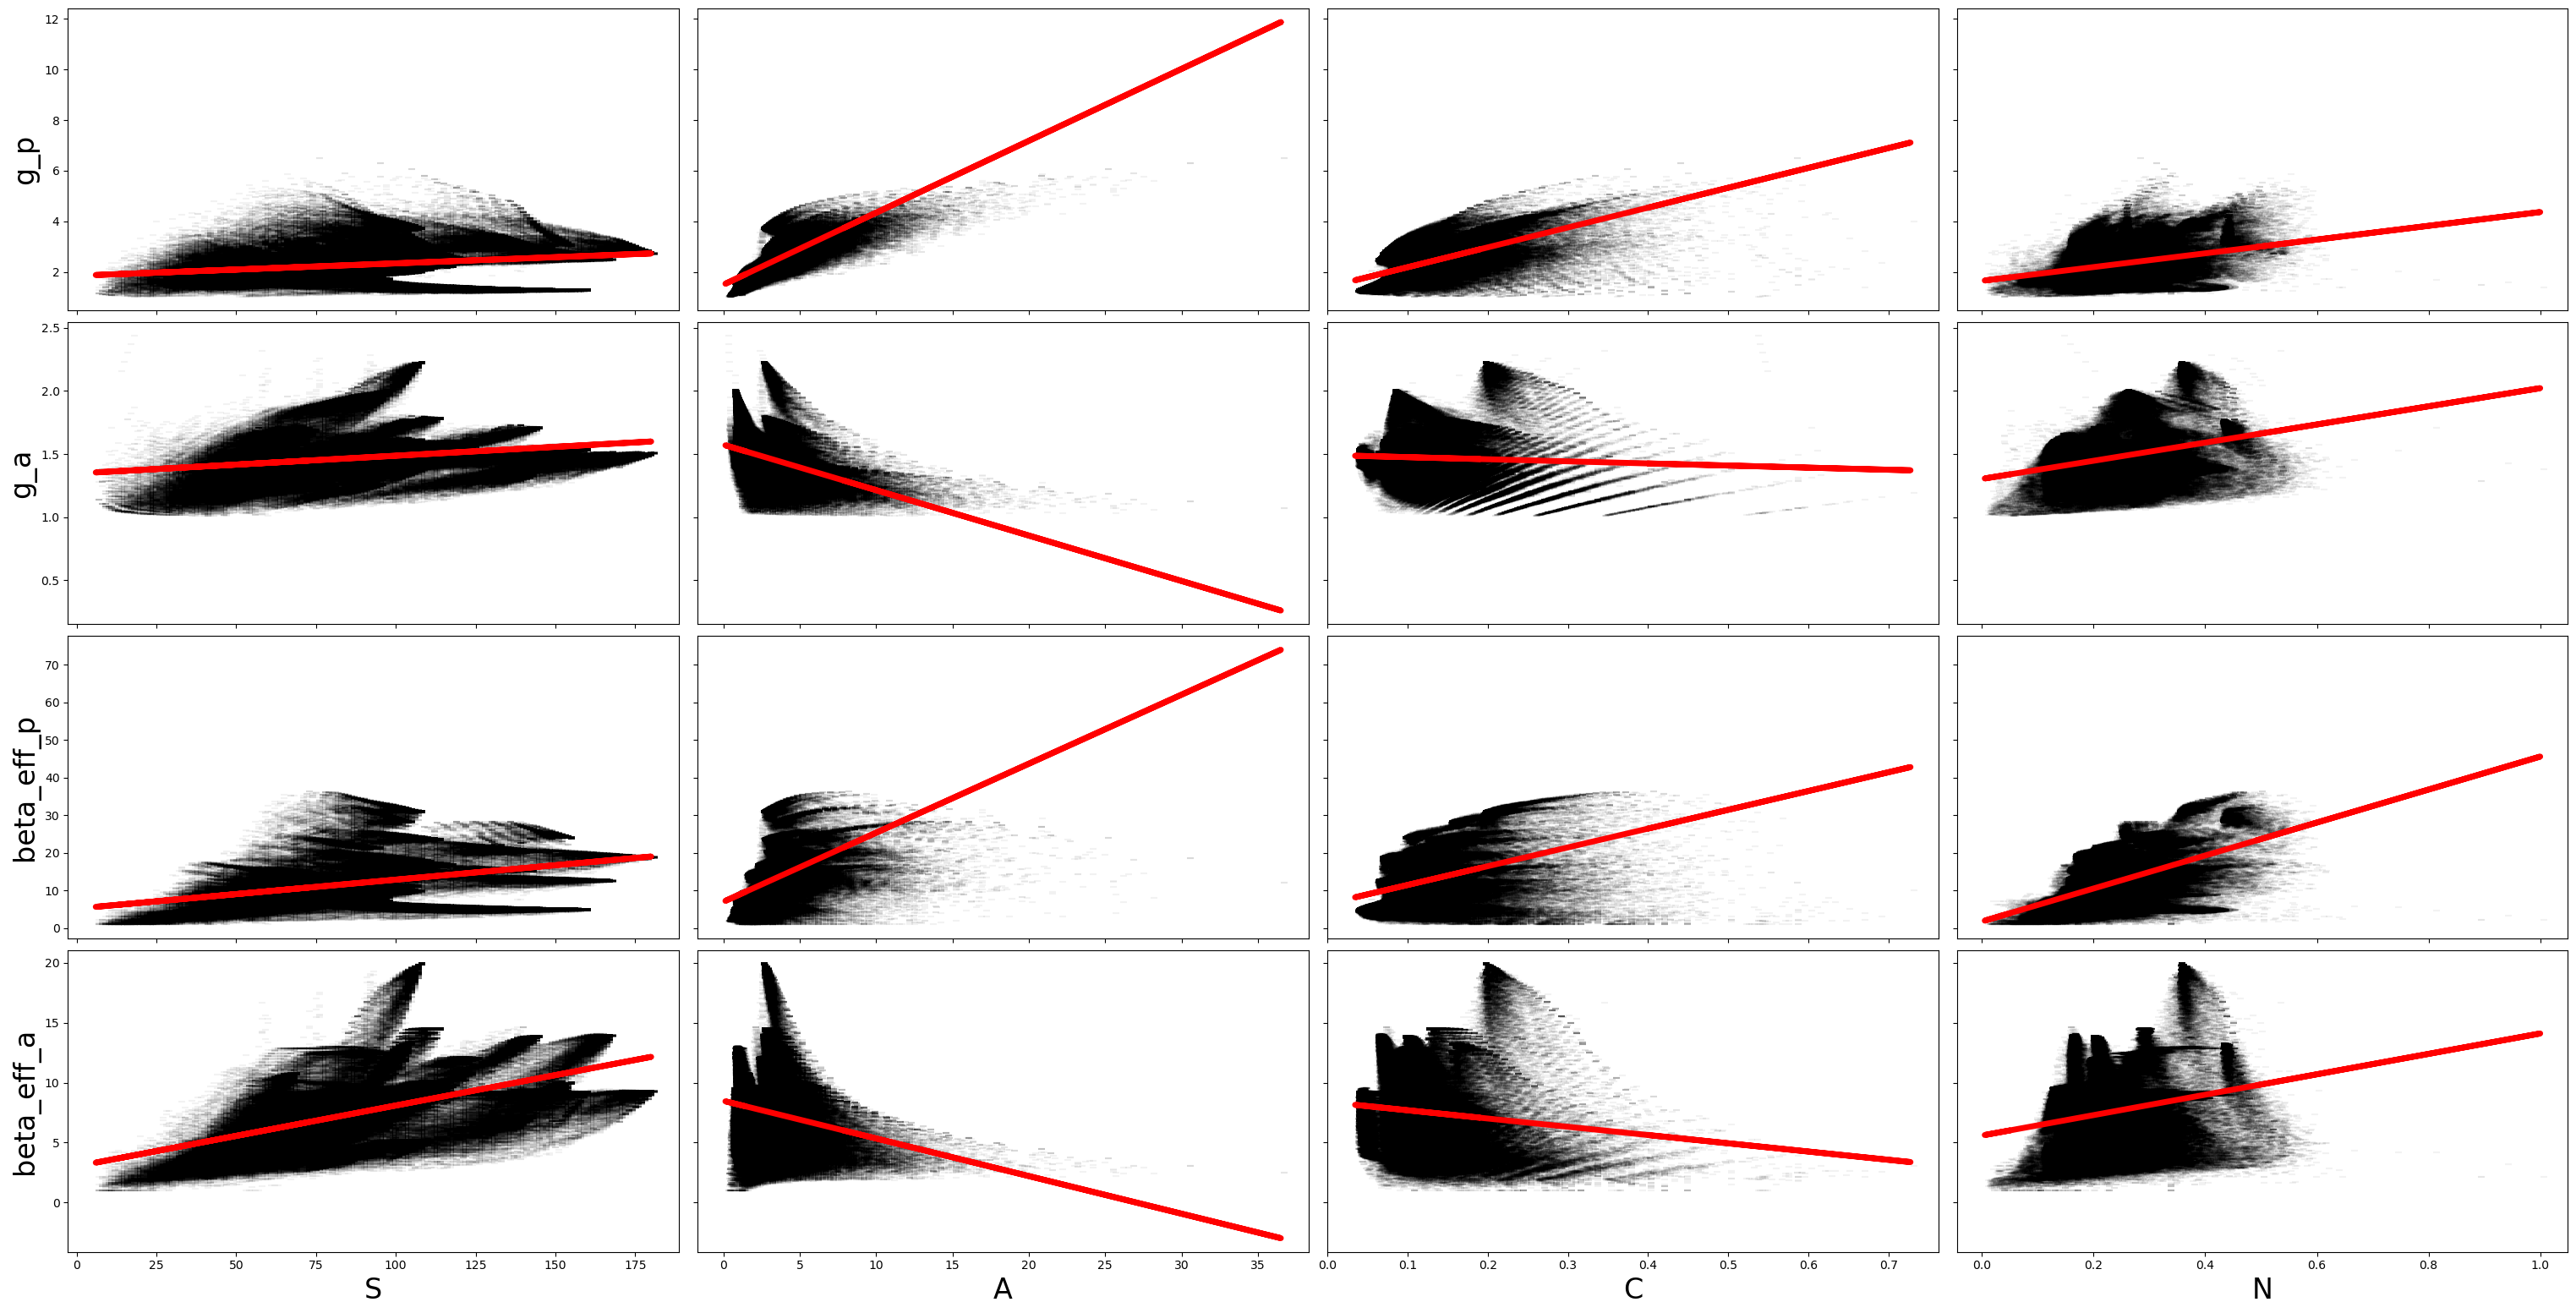

In [25]:
D = DF.copy()
D.drop(D[ D['N'] == 0 ].index ,inplace = True)
D.dropna(axis = 0, inplace = True)
#D = D[D['Abundance'] > 1.0]
D.reset_index(drop = True, inplace = True)

f, ax = plt.subplots(4,4, figsize = (30,15), dpi = 100, sharey = 'row', sharex = 'col')
f.tight_layout(pad = 0)

V_lst = ['S','A','C','N']
Vy_lst = ['g_p', 'g_a', 'beta_eff_p', 'beta_eff_a']

for row, Vy in enumerate(Vy_lst):
    for col, V in enumerate(V_lst):

        X_seq = np.array(D[V]).reshape(-1,1)
        Y_seq = np.array(D[Vy]).reshape(-1,1)

        if Vy == 'Ob Abundance':
            Y_seq = (Y_seq - 0) / (14-0)
        
        ax[row,col].scatter(X_seq,Y_seq, alpha = 0.05, color = 'black', marker = 1)

        regr = LinearRegression().fit(X_seq,Y_seq)
        ax[row,col].plot(X_seq,regr.predict(X_seq),color="red", linewidth = 5)

        ax[-1, col].set_xlabel(V, fontsize = 24)
        ax[row, 0].set_ylabel(Vy, fontsize = 24)

#ax[0,0].set_ylim([0.0, 1.0])
#ax[1,0].set_ylim([0, 300])
#ax[2,0].set_ylim([0.0, 1.0]) 

(0.0, 1.0)

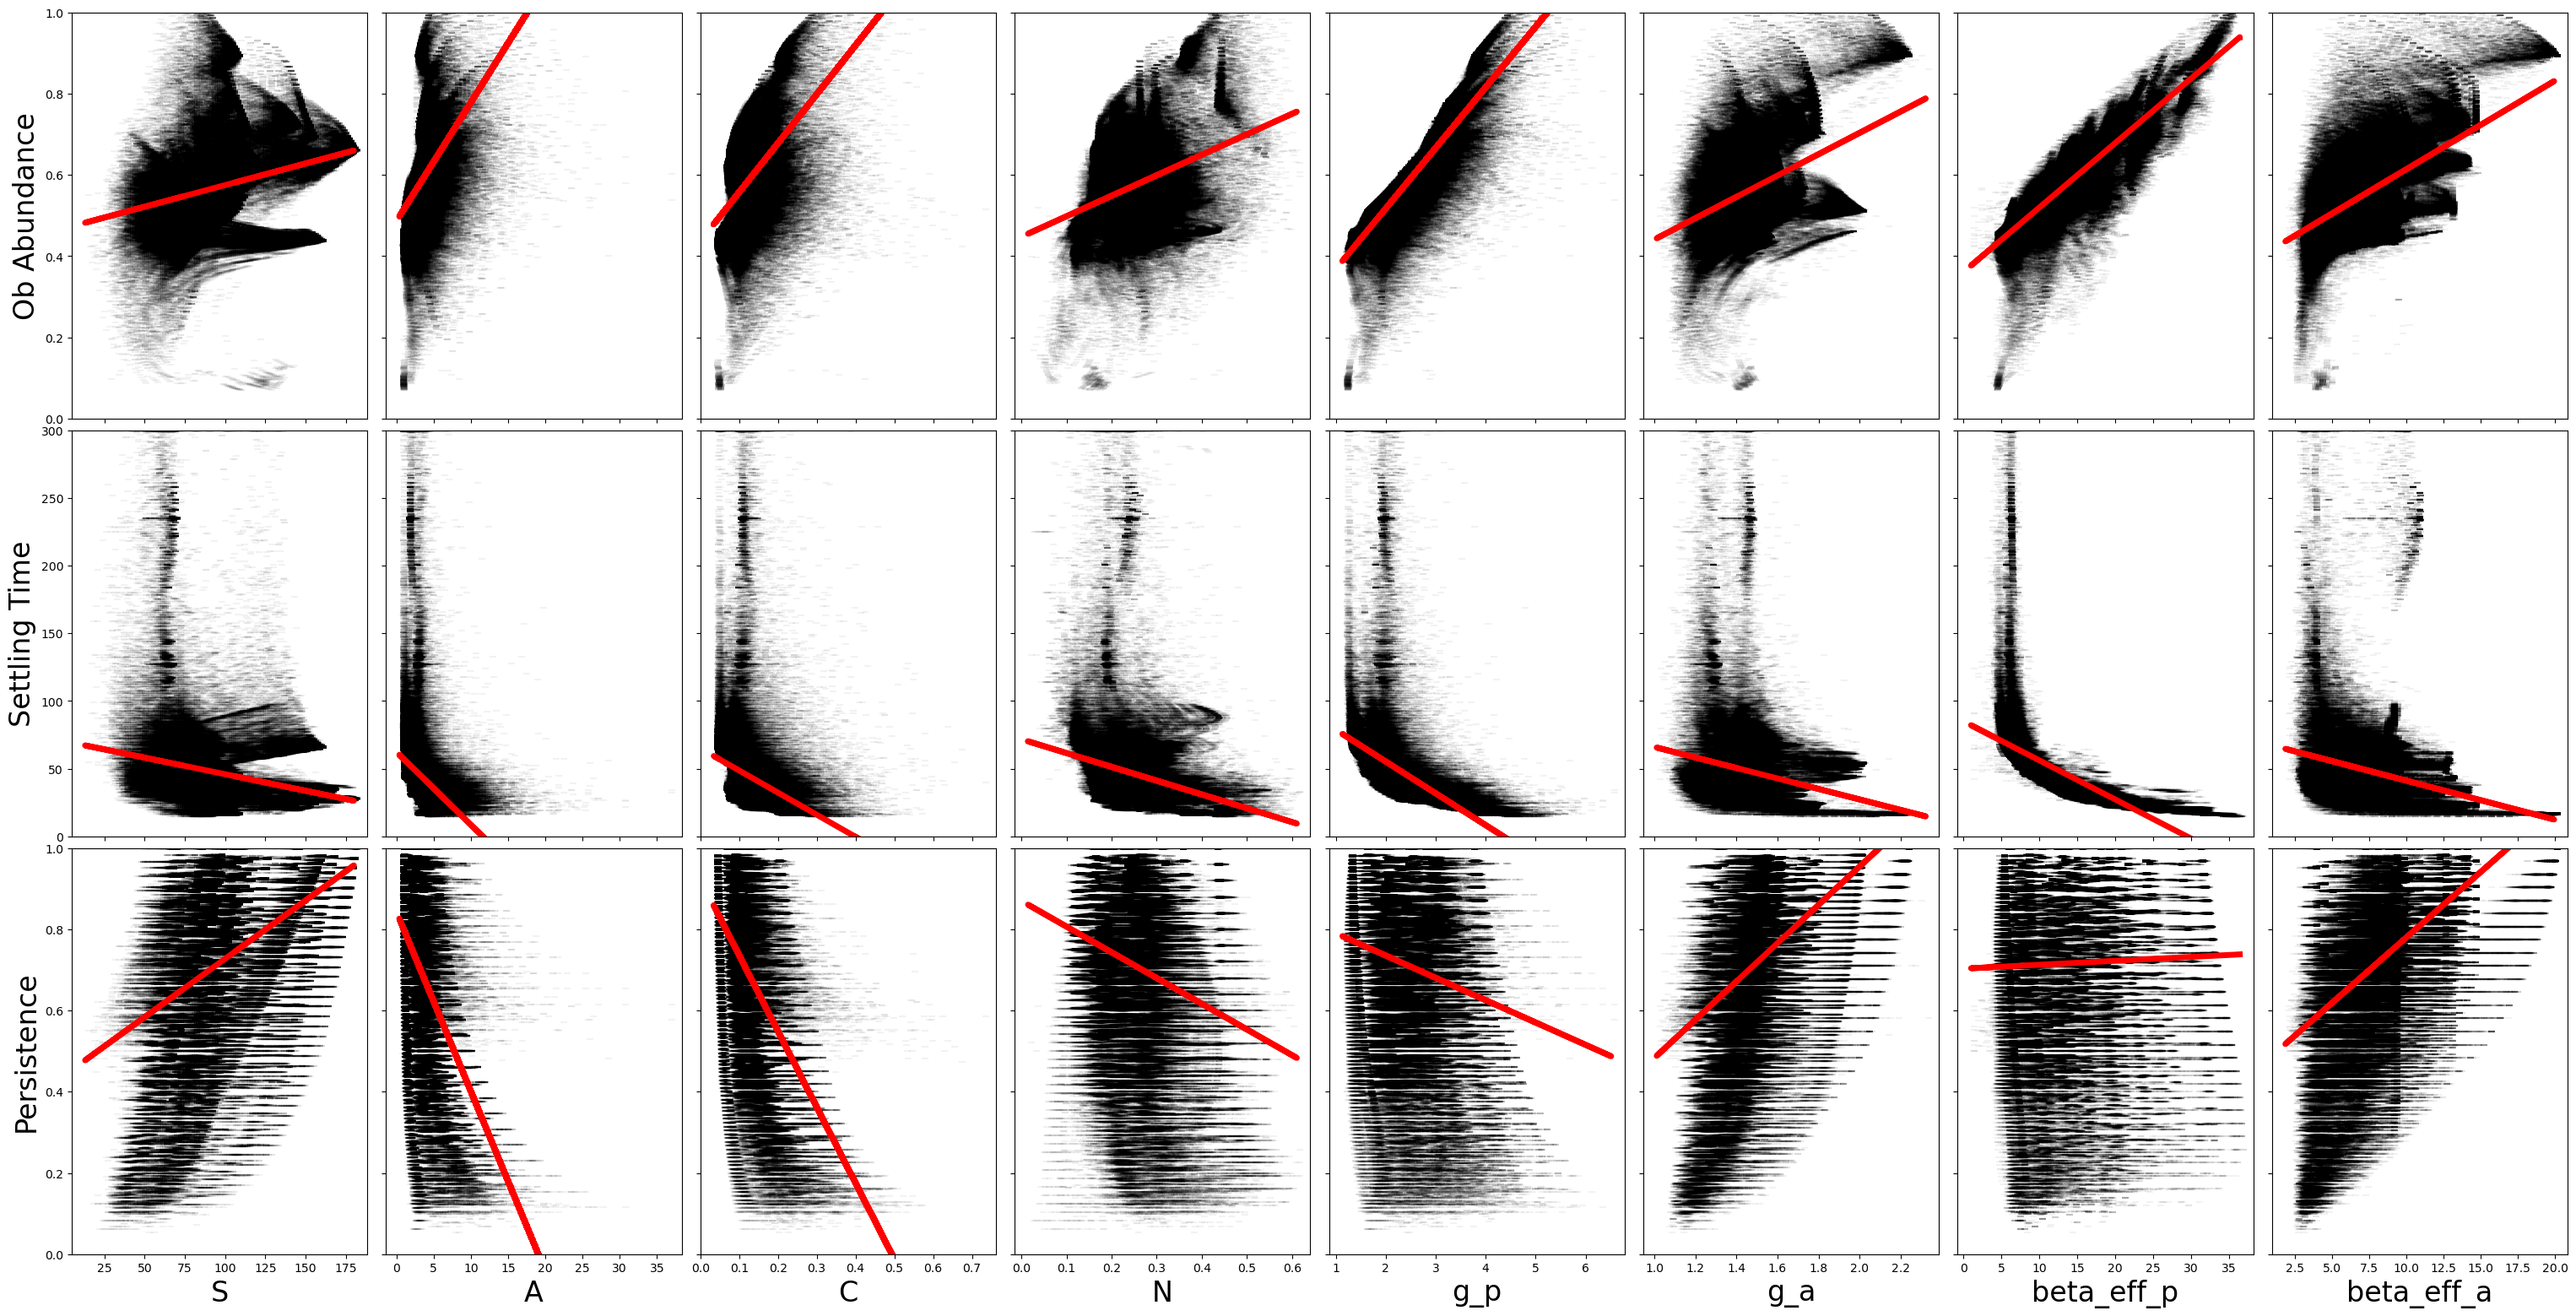

In [24]:
DATA_TYPE, NetworkName_Solved_df, M = CASE_init('Real_1D')
loc = '01'
X = {}
for NetworkName in M.keys():
    FileName = os.path.join(os.getcwd(), 'Code', '01_Species_Reintroductions', '05_Analysis', 'Dyna_SR', f"{loc}", f"{NetworkName}.pkl")
    X[NetworkName] = UnpickleObj(FileName)

DF = pd.DataFrame([], columns=['n','m','L','S','A','C','N','g_p','g_a','beta_eff_p','beta_eff_a','Abundance','Ob Abundance','Settling Time','Persistence'])
for key in X.keys():
    X[key] = X[key].apply(pd.to_numeric)
    X[key].drop_duplicates(inplace=True, ignore_index=True)
    X[key].drop(X[key][ X[key]['Ob Abundance'] == 0 ].index ,inplace = True)
    DF = pd.concat([DF,X[key]], ignore_index = True)
DF = DF.apply(pd.to_numeric)
DF.sort_values(by = ['Abundance', 'Ob Abundance'], axis = 0, inplace = True, ignore_index = True)
DF.drop(DF[ DF['Ob Abundance'] == 0 ].index ,inplace = True)
DF.reset_index(drop = True, inplace = True)

D = DF.copy()
D.drop(D[ D['N'] == 0 ].index ,inplace = True)
D.dropna(axis = 0, inplace = True)
D = D[D['Abundance'] > 1.0]
D.reset_index(drop = True, inplace = True)

f, ax = plt.subplots(3,4+4, figsize = (30,15), dpi = 100, sharey = 'row', sharex = 'col')
f.tight_layout(pad = 0)

V_lst = ['S','A','C','N', 'g_p', 'g_a', 'beta_eff_p', 'beta_eff_a']
Vy_lst = ['Ob Abundance', 'Settling Time', 'Persistence']

for row, Vy in enumerate(Vy_lst):
    for col, V in enumerate(V_lst):

        X_seq = np.array(D[V]).reshape(-1,1)
        Y_seq = np.array(D[Vy]).reshape(-1,1)

        if Vy == 'Ob Abundance':
            Y_seq = (Y_seq - 0) / (14-0)
        
        ax[row,col].scatter(X_seq,Y_seq, alpha = 0.05, color = 'black', marker = 1)

        regr = LinearRegression().fit(X_seq,Y_seq)
        ax[row,col].plot(X_seq,regr.predict(X_seq),color="red", linewidth = 5)

        ax[-1, col].set_xlabel(V, fontsize = 24)
        ax[row, 0].set_ylabel(Vy, fontsize = 24)

ax[0,0].set_ylim([0.0, 1.0])
ax[1,0].set_ylim([0, 300])
ax[2,0].set_ylim([0.0, 1.0])

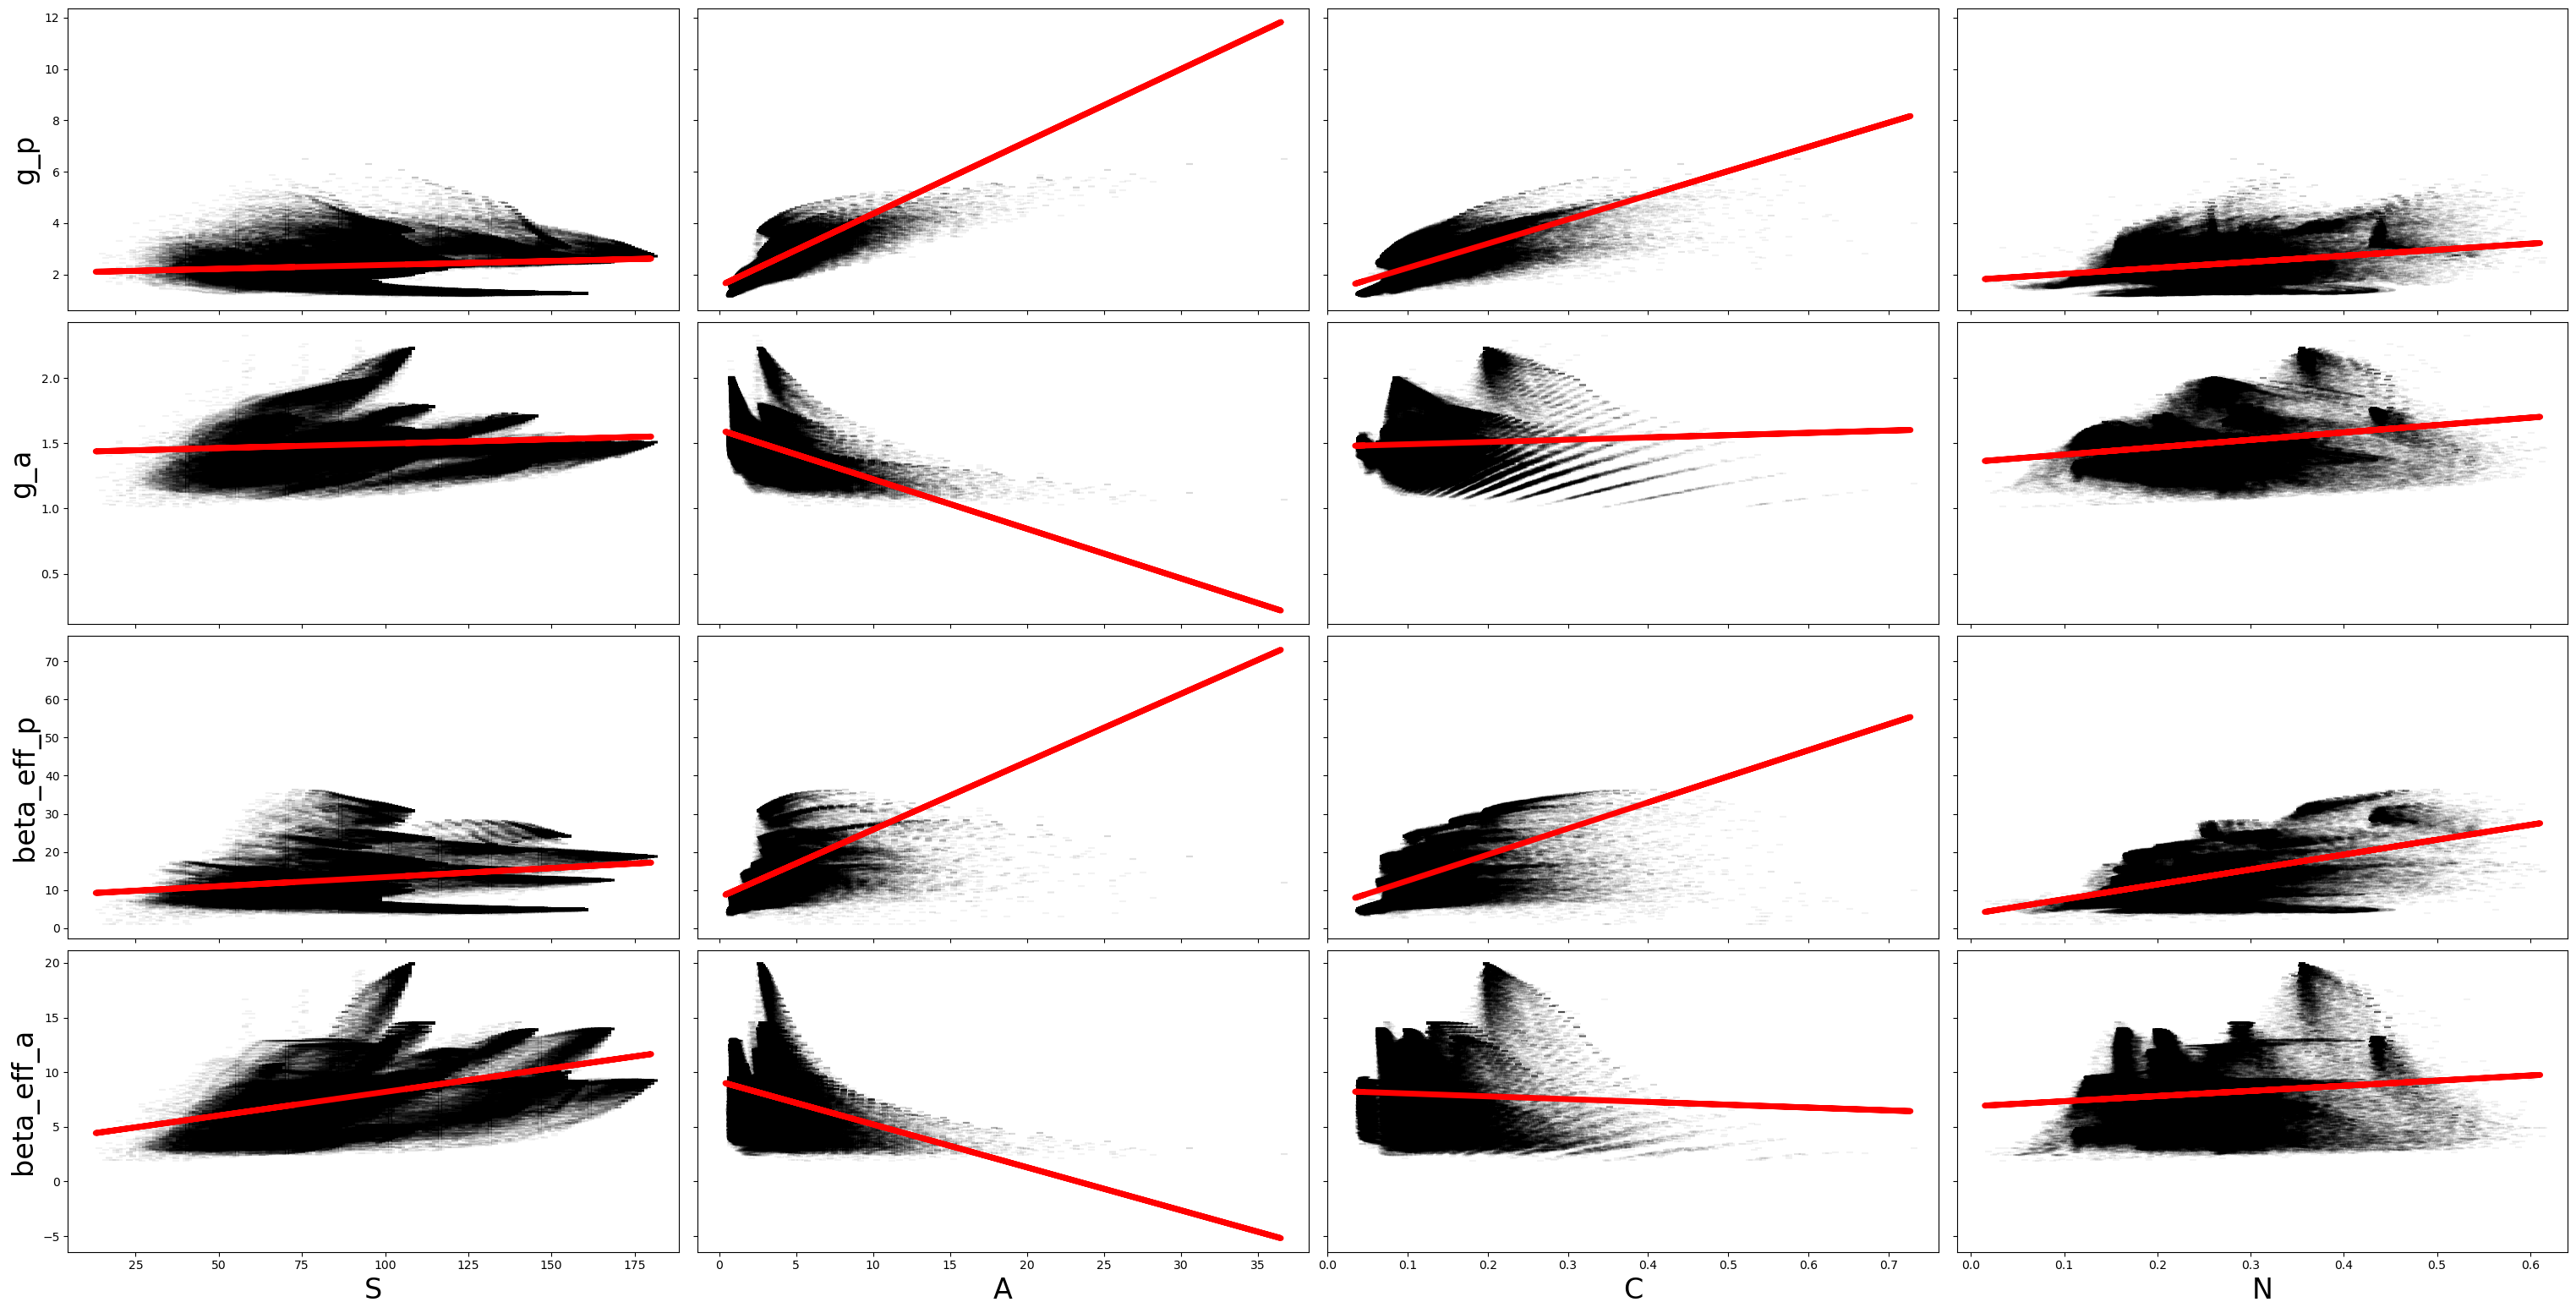

In [12]:
DATA_TYPE, NetworkName_Solved_df, M = CASE_init('Real_1D')
loc = '01'
X = {}
for NetworkName in M.keys():
    FileName = os.path.join(os.getcwd(), 'Code', '01_Species_Reintroductions', '05_Analysis', 'Dyna_SR', f"{loc}", f"{NetworkName}.pkl")
    X[NetworkName] = UnpickleObj(FileName)

DF = pd.DataFrame([], columns=['n','m','L','S','A','C','N','g_p','g_a','beta_eff_p','beta_eff_a','Abundance','Ob Abundance','Settling Time','Persistence'])
for key in X.keys():
    X[key] = X[key].apply(pd.to_numeric)
    X[key].drop_duplicates(inplace=True, ignore_index=True)
    X[key].drop(X[key][ X[key]['Ob Abundance'] == 0 ].index ,inplace = True)
    DF = pd.concat([DF,X[key]], ignore_index = True)
DF = DF.apply(pd.to_numeric)
DF.sort_values(by = ['Abundance', 'Ob Abundance'], axis = 0, inplace = True, ignore_index = True)
DF.drop(DF[ DF['Ob Abundance'] == 0 ].index ,inplace = True)
DF.reset_index(drop = True, inplace = True)

D = DF.copy()
D.drop(D[ D['N'] == 0 ].index ,inplace = True)
D.dropna(axis = 0, inplace = True)
D = D[D['Abundance'] > 1.0]
D.reset_index(drop = True, inplace = True)

f, ax = plt.subplots(4,4, figsize = (30,15), dpi = 100, sharey = 'row', sharex = 'col')
f.tight_layout(pad = 0)

V_lst = ['S','A','C','N']
Vy_lst = ['g_p', 'g_a', 'beta_eff_p', 'beta_eff_a']

for row, Vy in enumerate(Vy_lst):
    for col, V in enumerate(V_lst):

        X_seq = np.array(D[V]).reshape(-1,1)
        Y_seq = np.array(D[Vy]).reshape(-1,1)

        if Vy == 'Ob Abundance':
            Y_seq = (Y_seq - 0) / (14-0)
        
        ax[row,col].scatter(X_seq,Y_seq, alpha = 0.05, color = 'black', marker = 1)

        regr = LinearRegression().fit(X_seq,Y_seq)
        ax[row,col].plot(X_seq,regr.predict(X_seq),color="red", linewidth = 5)

        ax[-1, col].set_xlabel(V, fontsize = 24)
        ax[row, 0].set_ylabel(Vy, fontsize = 24)

#ax[0,0].set_ylim([0.0, 1.0])
#ax[1,0].set_ylim([0, 300])
#ax[2,0].set_ylim([0.0, 1.0]) 